# Import

In [1]:
import PyPDF2
import pandas as pd
import re
import numpy as np
import os
import fitz
from PIL import Image
import io
from functools import partial
import scipy
import skimage
from pyproj import Geod
import cv2 as cv
from scipy import ndimage as ndi
import copy
from numba import njit

from collections import Counter

from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from scipy.spatial.distance import cdist

from skimage.morphology import remove_small_objects

import pylab
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt

import simplekml

from skimage.io import imread
from scipy import ndimage as ndi
from skimage import feature
from skimage.color import rgb2gray 
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
import matplotlib.pyplot as plt
from skimage import filters

from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting'

In [2]:
table = pd.read_csv(base_dir + '/example_table.csv', dtype=str, sep='\t')
table['Threatened Species'] = 'None mentioned'
table['Map'] = False
species = pd.read_csv('threatened_species_202010.csv')

Extract "Threatened Species" and "Map?" column.

In [3]:
example_folders = [x[0].replace('/','') + '_' + x[1].replace('/','') for x in table[['Reference Number', 'Date of notice']].values]

In [4]:
# Check for scientific names 
# Loop through pdf files. Convert pdf to text. Search for scientific names.
folders = os.listdir("./files")

In [5]:
folders_revised = []
for folder in folders:
    for example_folder in example_folders:
        if example_folder in folder:
            folders_revised.append(folder)

In [6]:
folders_revised = list(set(folders_revised))
len(folders_revised)

93

In [7]:
folders=folders_revised

In [66]:
# Loop through folders
for folder in folders_revised:
    print(folder)
    try:
        fn = folder.split('_')[0] + '_' + folder.split('_')[1] + '_combined.pdf'
        pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
        pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
    except:
        try:
            fn = folder + '_combined.pdf'
            pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
            pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
        except:
            continue

    try:
        pages = [
            pdf_reader.getPage(i).extractText().replace('\n', '') 
            for i in range(pdf_reader.numPages)
        ]
    except:
        continue
    text = ''.join(pages)
    
    text_lower = text.lower()
    sci_name = species['Scientific Name'].apply(lambda x: x.lower()).values
    comm_name = species['Common Name'].loc[
        np.logical_and(
            species['Common Name'] != 'a shrub', species['Common Name'] != '-'
        )
    ].apply(lambda x: x.lower()).values

    [sci_name_exist, comm_name_exist] = [
        [
            species['Common Name'].values[i] + ', ' 
            + species['Scientific Name'].values[i] + ' (' 
            +  species['Threatened status'].values[i] + ')' 
            for i in range(len(name)) if name[i] in text.lower()
        ]
        for name in [sci_name, comm_name]
    ]
    
    if 'coordinates' in text.lower() or 'latitude' in text.lower() or 'longitude' in text.lower() or ' map ' in text.lower():
        coordinates_mentioned = True
    else:
        coordinates_mentioned = False

    species_mentioned = sorted(
        list(set(sci_name_exist).union(set(comm_name_exist)))
    )
    species_mentioned = ', '.join(species_mentioned)
    
#     Extract text coordinates
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)
#     points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
#     points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

    id_nums = folder.split('_')
    date = id_nums[1][:2] + '/' + id_nums[1][2:4] + '/' + id_nums[1][4:]
    ref_num = id_nums[0][:4] + '/' + id_nums[0][4:]
    table['Threatened Species'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = species_mentioned
    table['Map'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = coordinates_mentioned

NameError: name 'folders_revised' is not defined

In [13]:
table.to_csv('example_revised_table.csv', index=False, header=True)

In [20]:
coords = coords.reshape(int(len(coords)/2),2)
coords_new = np.zeros_like(coords)
coords_new[:,1] = coords[:,0]
coords_new[:,0] = coords[:,1]

In [3]:
pdf_file_obj = open('example_referral.pdf', 'rb')
pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
pages = [pdf_reader.getPage(i).extractText().replace('\n', '') for i in range(pdf_reader.numPages)]

In [4]:
text = ''.join(pages)

Extract KML from text.

In [5]:
import fitz

In [6]:
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)

In [7]:
text

"Referral of proposed action  Proposed action title: Yangibana Rare Earths Project  1 Summary of proposed action  1.1 Short description Hastings Technology Metals Limited (Hastings) proposes to develop the Yangibana Rare Earths Project (the Proposal), located approximately 270 km east-northeast of Carnarvon, in the Upper Gascoyne region of Western Australia (WA).  The Proposal will involve mining ferrocarbonatite-magnetite-rare earth bearing dykes.  Proposal activities include construction, mining, processing, decommissioning and rehabilitation of a rare earth mine, and associated infrastructure.  The Proposal is expected to have a mine life of approximately seven years. 1.2 Latitude and longitude Polygon enclosing entire referral area. Points are listed in a clockwise order.  Latitude Longitude Point degrees minutes seconds degrees minutes seconds 1 -23:54:44.60 S  116:05:52.08 E 2 -23:54:09.76 S  116:06:12.24 E 3 -23:52:05.05 S  116:07:43.68 E 4 -23:50:13.59 S  116:10:00.12 E 5 -23:4

In [8]:
points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

In [9]:
def convert_to_decimal(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(':',' ')
    new = new.split()
    new_dir = new.pop()
    return (abs(float(new[0]))+float(new[1])/60.0+float(new[2])/3600.0) * direction[new_dir]

In [10]:
points_lat = [convert_to_decimal(i) for i in points_lat]
points_lon = [convert_to_decimal(i) for i in points_lon]

In [11]:
len(points_lat)
# len(points_lon)

43

In [21]:
kml_coords = [(points_lon[i], points_lat[i]) for i in range(len(points_lat))]

In [22]:
kml_coords

[(116.09779999999999, -23.912388888888888),
 (116.1034, -23.90271111111111),
 (116.1288, -23.868069444444444),
 (116.1667, -23.837108333333333),
 (116.1847, -23.83203888888889),
 (116.2014, -23.83203888888889),
 (116.2429, -23.857950000000002),
 (116.2667, -23.87602777777778),
 (116.2847, -23.88202777777778),
 (116.3014, -23.88202777777778),
 (116.3167, -23.923008333333335),
 (116.3232, -23.94103888888889),
 (116.3231, -23.9528),
 (116.3059, -23.96666944444444),
 (116.29169999999999, -23.96666944444444),
 (116.2423, -24.002580555555557),
 (116.2818, -24.0853),
 (116.2837, -24.09245),
 (116.2835, -24.09570833333333),
 (116.2831, -24.097158333333333),
 (116.2824, -24.098488888888888),
 (116.2814, -24.099619444444443),
 (116.2799, -24.100580555555556),
 (116.27695, -24.1019),
 (116.27629999999999, -24.10068888888889),
 (116.2709, -24.07348888888889),
 (116.25835, -24.06573888888889),
 (116.22840000000001, -24.048269444444447),
 (116.2269, -24.047127777777778),
 (116.22585000000001, -24.04

In [25]:
import simplekml

trans_green_style = simplekml.Style()
trans_green_style.linestyle.width = 1.5
trans_green_style.polystyle.color = '7d00ff00'
trans_green_style.name = 'trans_green_style'

kml = simplekml.Kml()
kml.document.name = "Referral Name Text Extract"
pol1 = kml.newpolygon(name = "Referral Area", outerboundaryis=kml_coords)
pol1.style.linestyle.width = 1.5
pol1.style = trans_green_style

In [43]:
kml.save('simple_kml_test.kml')

In [18]:
direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
test = points_lat[0]

# Extract from images.

In [2]:
sub_dir = '/map_data/20167676_01042016'
file = base_dir + sub_dir + '/20167676_01042016_combined.pdf'
pdf_file = fitz.open(file)
zoom_factor = 1

In [126]:
for page_index in range(len(pdf_file)):
    # get the page itself
    page = pdf_file[page_index]
    page_size = page.mediabox_size[0]*page.mediabox_size[1]
    image_list = page.getImageList()
    image_sizes = np.array([im[2]*im[3] for im in image_list])
#     save_page_image = np.array(image_sizes).sum() > 0.5*page_size
    save_page_image = ('legend' in page.getText().lower())
    
    if save_page_image:
        zoom_x = zoom_factor
        zomm_y = zoom_factor
        mat = fitz.Matrix(zoom_x, zomm_y) 
        pix = page.get_pixmap(matrix=mat)
        pix.writePNG(
            base_dir + sub_dir + '/pages/page-%i.png' % page.number
        )
        print('Saving page ' + str(page.number) + '.')

Saving page 19.
Saving page 20.
Saving page 22.
Saving page 26.
Saving page 27.
Saving page 32.
Saving page 103.
Saving page 104.
Saving page 109.
Saving page 110.
Saving page 111.
Saving page 112.
Saving page 113.
Saving page 114.
Saving page 121.
Saving page 126.
Saving page 127.
Saving page 128.
Saving page 129.
Saving page 130.
Saving page 131.


In [3]:
page_num = 109
file_name = 'page-' + str(page_num) + '.png'

im1 = imread(base_dir + sub_dir + '/pages/' + file_name)

im1_area = im1.shape[0]*im1.shape[1]

page = pdf_file[page_num]
blocks = page.getTextBlocks()

leg_txt_box_ind = np.argmax([('legend' in block[4].lower()) for block in blocks])
[x1, y1, x2, y2] = np.array(blocks[leg_txt_box_ind][:4])*zoom_factor
leg_txt_coords = [(x1+x2)/2, (y1+y2)/2]

In [4]:
from collections import namedtuple
from operator import mul
from functools import reduce

Info = namedtuple('Info', 'start height')

def max_size(mat, value=0):
    """Find height, width of the largest rectangle containing all `value`'s.
    For each row solve "Largest Rectangle in a Histrogram" problem [1]:
    [1]: http://blog.csdn.net/arbuckle/archive/2006/05/06/710988.aspx
    """
    it = iter(mat)
    hist = [(el==value) for el in next(it, [])]
    max_size = max_rectangle_size(hist, 0)
    row_count = 1
    for row in it:
        hist = [(1+h) if el == value else 0 for h, el in zip(hist, row)]
        max_size = max(
            max_size, max_rectangle_size(hist, row_count), key=area
        )
        row_count += 1
    return max_size

def max_rectangle_size(histogram, row_count):
    """Find height, width of the largest rectangle that fits entirely under
    the histogram.
    """
    stack = []
    top = lambda: stack[-1]
    max_size = (0, 0, row_count, 0) # height, width of the largest rectangle
    pos = 0 # current position in the histogram
    for pos, height in enumerate(histogram):
        start = pos # position where rectangle starts
        while True:
            if not stack or height > top().height:
                stack.append(Info(start, height)) # push
            elif stack and height < top().height:
                max_size = max(
                    max_size, 
                    (
                        top().height, 
                        (pos - top().start), 
                        row_count-top().height,
                        top().start
                    ),
                    key=area
                )
                start, _ = stack.pop()
                continue
            break # height == top().height goes here

    pos += 1
    for start, height in stack:
        max_size = max(
            max_size, 
            (
                height, 
                (pos - start), 
                row_count-height,
                start
            ), 
            key=area
        )

    return max_size

def area(size):
    return reduce(mul, size[0:2])

In [39]:
# Convert image to grayscale to look for legend box
gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
binary = copy.deepcopy(gray)
# Assume legend has a near white background and a border
# Create a binary image that is >0 only when white or near white
grey_thresh = 255
binary[binary < grey_thresh]=0

# Search for contours in the binary image
contours, hierarchy = cv.findContours(
    binary, 
    cv.RETR_TREE, 
    cv.CHAIN_APPROX_SIMPLE
)

# Look for legend box
# Filter contours to those of a plausible size for legend box
leg_inds = [
    i for i in range(len(contours))
    if cv.contourArea(contours[i]) >= 0.005*im1.shape[0]*im1.shape[1]
    and cv.contourArea(contours[i]) <= 0.5*im1.shape[0]*im1.shape[1]
]

# num_children_list = []
# for i in range(len(leg_inds)):
#     num_children = 0
#     child = hierarchy[0][leg_inds[i]][2]
#     while child != -1:
#         num_children += 1
#         child = hierarchy[0][child][0]
#     num_children_list.append(num_children)

# Assume contour with most children is the legend
# Bad idea
# ind = leg_inds[np.argmax(num_children_list)]
distances = []
for i in range(len(leg_inds)):
    c = contours[leg_inds[i]].squeeze(axis=1)
    dist = [
        np.sqrt(
            (p[0]-leg_txt_coords[0])**2+(p[1]-leg_txt_coords[1])**2
        ) for p in c
    ]
    distances.append(max(dist))
ind = leg_inds[np.argmin(distances)]

# distances = []
# for i in range(len(leg_inds)):
#     c = contours[leg_inds[i]]
#     M = cv.moments(c)
#     cx = int(M['m10']/M['m00'])
#     cy = int(M['m01']/M['m00'])
#     dist = np.sqrt(
#         (cx-leg_txt_coords[0])**2+(cy-leg_txt_coords[1])**2
#     )
#     distances.append(dist)
# ind = np.argmin(distances)     
legend = cv.drawContours(
    np.zeros_like(im1), contours, ind, (255,255,255), -1
)
legend = (cv.cvtColor(legend, cv.COLOR_BGR2GRAY) > 0).astype(int)

 # Find maximal inscribed rectangle and assume this is the legend box.
rows, columns = np.where(legend > 0)
obj_range = [
    np.amin(rows), np.amax(rows), np.amin(columns), np.amax(columns)
]
rec = max_size(
    legend[obj_range[0]:obj_range[1], obj_range[2]:obj_range[3]],1
)
rec = list(rec)
rec[2] += obj_range[0]
rec[3] += obj_range[2]

child = hierarchy[0][ind][2]
obj_inds = []
leg_area = rec[0]*rec[1]

# Define legend text boxes
leg_blocks = []
leg_blocks_text = []
for i in range(len(blocks)):
    block = blocks[i]
    in_rec = (
        zoom_factor*round(block[0]) >= rec[3]
        and zoom_factor*round(block[2]) <= rec[3]+rec[1]
        and zoom_factor*round(block[1]) >= rec[2]
        and zoom_factor*round(block[3]) <= rec[2]+rec[0]
    )
    if in_rec:
        leg_blocks.append(
            np.round(np.array(block[0:4])*zoom_factor).astype(int)
        )
        leg_blocks_text.append(
            block[4].replace('!','').replace('\n','').replace('LEGEND','')
        )

leg_blocks = np.array(leg_blocks)

while child != -1:

    # Check if contour points in legend rectangle
    child_ar = contours[child].squeeze(axis=1)
    
    child_rows = child_ar[:,1]
    child_columns = child_ar[:,0]

    row_cond = child_rows >= rec[2]
    row_cond *= child_rows <= rec[2] + rec[0]
    col_cond = child_columns >= rec[3]
    col_cond *= child_columns <= rec[3] + rec[1]

    in_rec = np.all(row_cond*col_cond)

    # Here just filter for objects of good size inside rec
    if (
        cv.contourArea(contours[child]) > 0.002*leg_area
        and cv.contourArea(contours[child]) < 0.5*leg_area
        and in_rec
    ):
        obj_inds.append(child)

    child = hierarchy[0][child][0]

# Now filter for bigger objects we definitely want
big_obj_inds = [
    x for x in obj_inds 
    if cv.contourArea(contours[x]) > 0.05*leg_area
]

# Now filter for smaller objects not in text boxes.
# Imperfect filtering as sometimes text boxes too big
small_obj_inds = []

for child in obj_inds:

    # Check if contours points in text boxes extracted from pdf
    child_ar = contours[child].squeeze()
    col_cond = leg_blocks[:,0] <= child_ar[:,0,None]
    col_cond *= child_ar[:,0,None] <= leg_blocks[:,2]
    row_cond = leg_blocks[:,1] <= child_ar[:,1,None]
    row_cond *= child_ar[:,1,None] <= leg_blocks[:,3] 

    in_text = (row_cond*col_cond).any()

    if not in_text:
        small_obj_inds.append(child)
                
leg_obj_inds = list(set(small_obj_inds).union(set(big_obj_inds)))
leg_obj_labels = np.zeros(im1.shape[:2], dtype=float)
for i in range(len(leg_obj_inds)):
    leg_obj_labels += cv.drawContours(
        np.zeros(im1.shape[:2]), contours, leg_obj_inds[i], i+1, -1
    )
    child = hierarchy[0][leg_obj_inds[i]][2]
    while child != -1:
        child_labelled = cv.drawContours(
            np.zeros(im1.shape[:2]), contours, child, 1, -1
        )
        if np.all(im1[child_labelled>0] == [255,255,255]):
            leg_obj_labels[child_labelled>0] = 0
        child = hierarchy[0][child][0]
                             
leg_obj_labels = leg_obj_labels.astype(int)
    
leg_contours = [contours[ind].squeeze() for ind in leg_obj_inds]

# Get corners of legend boxes
text_corners = [text_tl, text_tr, text_bl, text_br] = [
    leg_blocks[:,inds] for inds in [[0,1], [2,1], [0,3], [2,3]]
]

corners_text = []
for i in range(len(leg_blocks)):
    for corner in text_corners:
        corners_text.append(corner[i])

box_nums = []
for con in leg_contours:
    # Assume text likely beside icon, so penalise vertical distances
    distances = cdist(
        con, corners_text, 'euclidean', w=[1, 2]
    )
    box_num = np.argmin(np.min(distances, axis=0))
    box_num = np.floor(box_num/4).astype(int)
    box_nums.append(box_num)
    
leg_colours = []
for i in range(1,len(leg_obj_inds)+1):
    colours = im1[leg_obj_labels == i].tolist()
    colours = [tuple(c) for c in colours]
    leg_colours += colours
    
bw_thresh = 30
    
leg_colours = [
    c for c in leg_colours 
    if np.linalg.norm(np.array(c)-[255, 255, 255]) > bw_thresh
    and np.linalg.norm(np.array(c)-[0, 0, 0]) > bw_thresh
]
    
cond = np.zeros_like(leg_obj_labels)
for i in range(1, len(leg_obj_inds)+1):
    cond += (leg_obj_labels == i)
cond = (cond>0)

c_count_ratio = 0.00005
c_count_thresh = c_count_ratio*sum(Counter(leg_colours).values())

leg_com_col = []

for i in range(len(Counter(leg_colours).most_common())):
    if Counter(leg_colours).most_common()[i][1] < c_count_thresh:
        break
    else:
        leg_com_col.append(Counter(leg_colours).most_common()[i][0]) 

[170, 189]
[157, 158, 159, 163, 167, 170, 177, 179, 181, 183, 187, 189, 196, 198]
[[ 975  375 1014  389]
 [1010  401 1089  412]
 [1010  426 1094  437]]


[array([[ 975,  375],
        [1010,  401],
        [1010,  426]]),
 array([[1014,  375],
        [1089,  401],
        [1094,  426]]),
 array([[ 975,  389],
        [1010,  412],
        [1010,  437]]),
 array([[1014,  389],
        [1089,  412],
        [1094,  437]])]

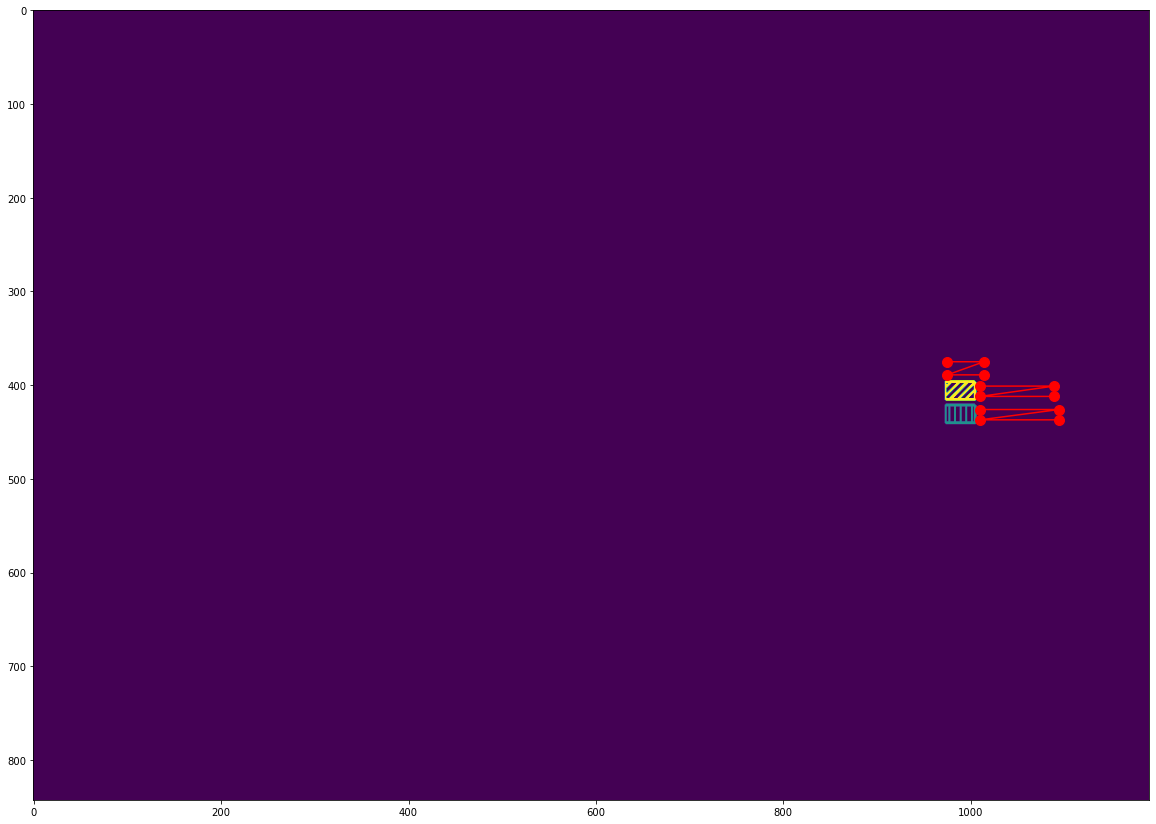

In [40]:
fig, ax = plt.subplots(figsize=(20,20))

ax.imshow(leg_obj_labels)
ax.plot([tc[0][0] for tc in text_corners], [tc[0][1] for tc in text_corners], '-or', markersize=10)
ax.plot([tc[1][0] for tc in text_corners], [tc[1][1] for tc in text_corners], '-or', markersize=10)
ax.plot([tc[2][0] for tc in text_corners], [tc[2][1] for tc in text_corners], '-or', markersize=10)
print(leg_obj_inds)
print(obj_inds)
print(leg_blocks)
box_nums
text_corners

In [143]:
print('Clustering colours in image.')
sample_ratio=0.05
im1_sample = shuffle(
    im1.reshape(im1.shape[0]*im1.shape[1],3)
)[:int(im1.shape[0]*im1.shape[1]*sample_ratio)]
kmeans = KMeans(random_state=0, n_clusters=16).fit(im1_sample)
cluster_labels = kmeans.predict(im1.reshape(im1.shape[0]*im1.shape[1],3))
cluster_labels += 1 + len(leg_obj_inds)

Clustering colours in image.


In [144]:
cluster_labels_revised = copy.deepcopy(cluster_labels)
cluster_colours = np.around(np.abs(kmeans.cluster_centers_)).astype(int)
min_distance = np.min(cdist(cluster_colours, leg_com_col), axis=1)
cluster_nums = sorted(np.unique(cluster_labels))
colour_thresh = 10
for i in range(len(cluster_nums)):
    if min_distance[i] < colour_thresh:
        cluster_labels_revised[
            cluster_labels_revised==cluster_nums[i]
        ] = 0

cluster_labels_revised = cluster_labels_revised.reshape(im1.shape[:2])
cluster_labels_revised[leg_obj_labels > 0] = 0

In [145]:
# Build an array of labels for training the segmentation.
# Here we use rectangles but visualization libraries such as plotly
# (and napari?) can be used to draw a mask on the image.
training_labels = leg_obj_labels + cluster_labels_revised

In [146]:
np.unique(leg_obj_labels)
leg_blocks

array([[ 37, 572,  83, 590],
       [ 66, 599, 147, 609],
       [ 66, 616, 150, 637],
       [ 66, 642, 151, 674],
       [ 66, 681, 180, 691],
       [ 66, 700, 118, 710]])

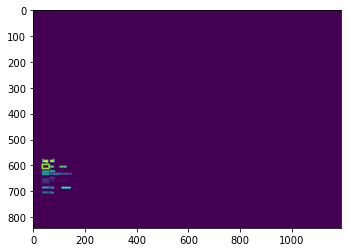

In [147]:
plt.imshow(leg_obj_labels)

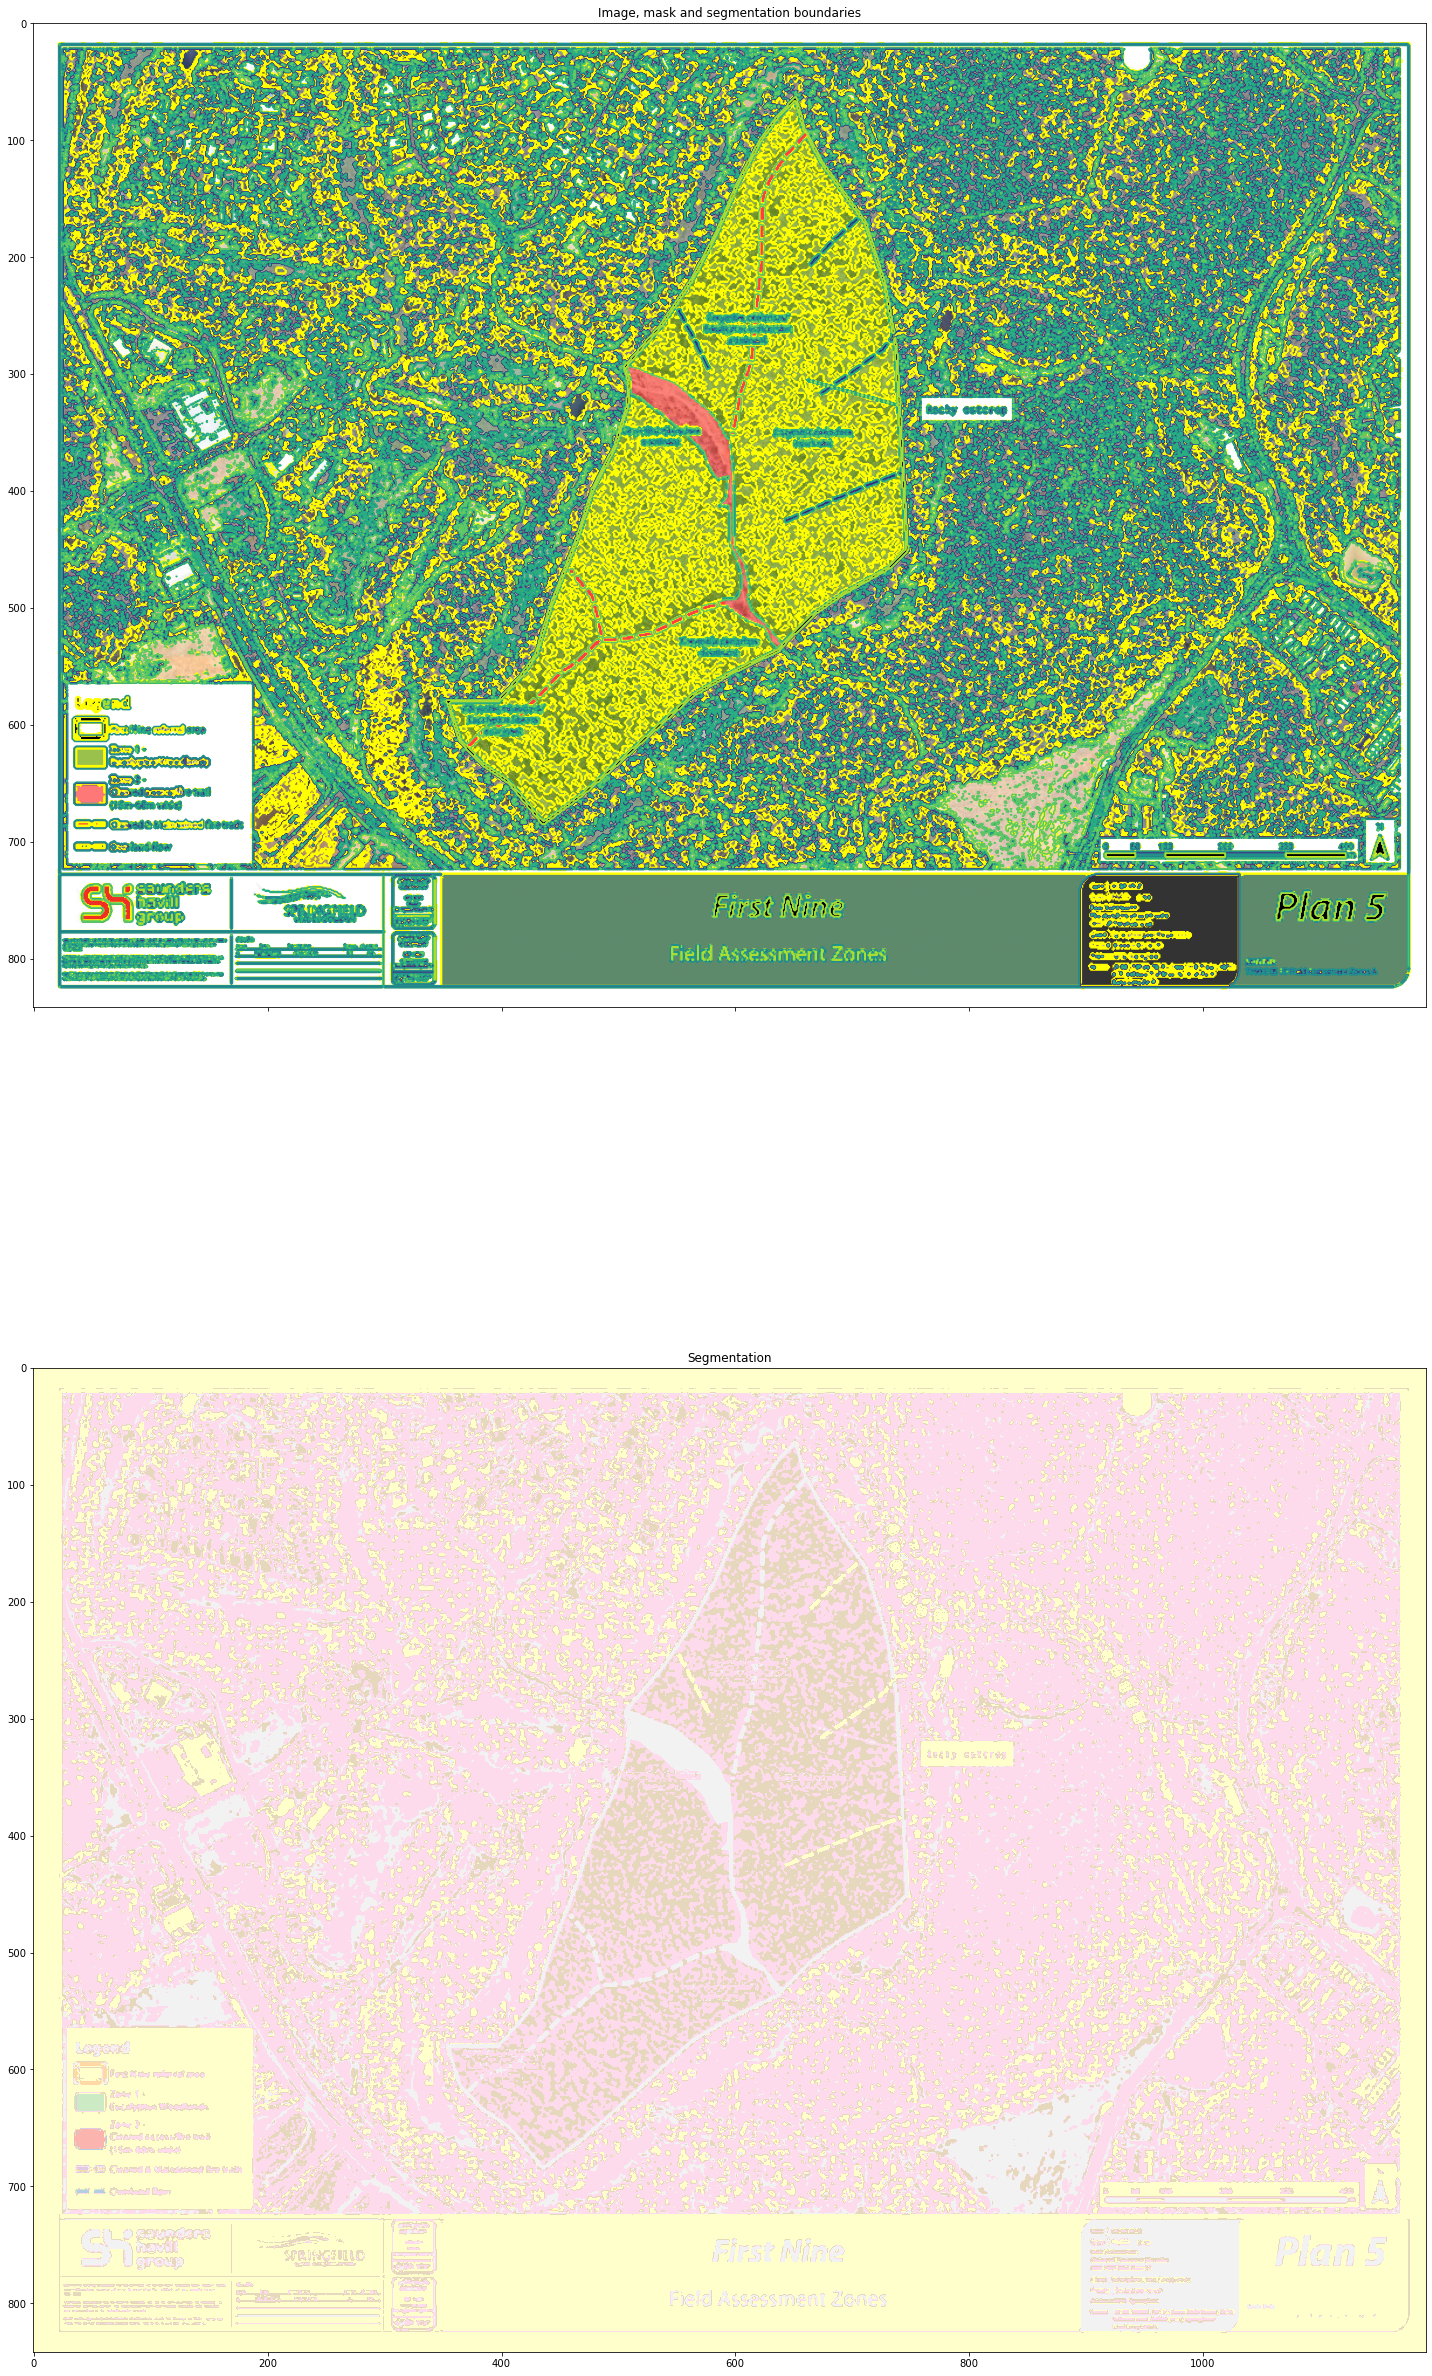

In [148]:
sigma_min = 1
sigma_max = 2
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(im1)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 40))
ax[0].imshow(segmentation.mark_boundaries(im1, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result, cmap='Pastel1')
ax[1].set_title('Segmentation')
fig.tight_layout()

# Manual coordinate extract.

In [149]:
# -*- coding: utf-8 -*-
# Advanced zoom example. Like in Google Maps.
# It zooms only a tile, but not the whole image. So the zoomed tile occupies
# constant memory and not crams it with a huge resized image for the large zooms.
import random
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk

from tkinter.simpledialog import askstring

class AutoScrollbar(ttk.Scrollbar):
    ''' A scrollbar that hides itself if it's not needed.
        Works only if you use the grid geometry manager '''
    def set(self, lo, hi):
        if float(lo) <= 0.0 and float(hi) >= 1.0:
            self.grid_remove()
        else:
            self.grid()
            ttk.Scrollbar.set(self, lo, hi)

    def pack(self, **kw):
        raise tk.TclError('Cannot use pack with this widget')

    def place(self, **kw):
        raise tk.TclError('Cannot use place with this widget')

class Zoom_Advanced(ttk.Frame):
    ''' Advanced zoom of the image '''
    def __init__(self, mainframe, path):
        ''' Initialize the main Frame '''
        ttk.Frame.__init__(self, master=mainframe)
        self.master.title('Right click to choose points.')
        # Vertical and horizontal scrollbars for canvas
        vbar = AutoScrollbar(self.master, orient='vertical')
        hbar = AutoScrollbar(self.master, orient='horizontal')
        vbar.grid(row=0, column=1, sticky='ns')
        hbar.grid(row=1, column=0, sticky='we')
        # Create canvas and put image on it
        self.canvas = tk.Canvas(self.master, highlightthickness=0,
                                xscrollcommand=hbar.set, yscrollcommand=vbar.set)
        self.canvas.grid(row=0, column=0, sticky='nswe')
        self.canvas.update()  # wait till canvas is created
        vbar.configure(command=self.scroll_y)  # bind scrollbars to the canvas
        hbar.configure(command=self.scroll_x)
        # Make the canvas expandable
        self.master.rowconfigure(0, weight=1)
        self.master.columnconfigure(0, weight=1)
        # Bind events to the Canvas
        self.canvas.bind('<Configure>', self.show_image)  # canvas is resized
        self.canvas.bind('<ButtonPress-1>', self.move_from)
        self.canvas.bind('<B1-Motion>',     self.move_to)
        self.canvas.bind('<MouseWheel>', self.wheel)  # with Windows and MacOS, but not Linux
        self.canvas.bind('<Button-5>',   self.wheel)  # only with Linux, wheel scroll down
        self.canvas.bind('<Button-4>',   self.wheel)  # only with Linux, wheel scroll up
        self.canvas.bind('<ButtonPress-3>', self.record_point)
        self.image = Image.open(path)  # open image
        self.width, self.height = self.image.size
        self.imscale = 1.0  # scale for the canvaas image
        self.delta = 1.3  # zoom magnitude
        # Put image into container rectangle and use it to set proper coordinates to the image
        self.container = self.canvas.create_rectangle(0, 0, self.width, self.height, width=0)
        self.show_image()

    def scroll_y(self, *args, **kwargs):
        ''' Scroll canvas vertically and redraw the image '''
        self.canvas.yview(*args, **kwargs)  # scroll vertically
        self.show_image()  # redraw the image

    def scroll_x(self, *args, **kwargs):
        ''' Scroll canvas horizontally and redraw the image '''
        self.canvas.xview(*args, **kwargs)  # scroll horizontally
        self.show_image()  # redraw the image

    def move_from(self, event):
        ''' Remember previous coordinates for scrolling with the mouse '''
        self.canvas.scan_mark(event.x, event.y)

    def move_to(self, event):
        ''' Drag (move) canvas to the new position '''
        self.canvas.scan_dragto(event.x, event.y, gain=1)
        self.show_image()  # redraw the image

    def wheel(self, event):
        ''' Zoom with mouse wheel '''
        x = self.canvas.canvasx(event.x)
        y = self.canvas.canvasy(event.y)
        bbox = self.canvas.bbox(self.container)  # get image area
        if bbox[0] < x < bbox[2] and bbox[1] < y < bbox[3]: pass  # Ok! Inside the image
        else: return  # zoom only inside image area
        scale = 1.0
        # Respond to Linux (event.num) or Windows (event.delta) wheel event
        if event.num == 5 or event.delta == -120:  # scroll down
            i = min(self.width, self.height)
            if int(i * self.imscale) < 30: return  # image is less than 30 pixels
            self.imscale /= self.delta
            scale        /= self.delta
        if event.num == 4 or event.delta == 120:  # scroll up
            i = min(self.canvas.winfo_width(), self.canvas.winfo_height())
            if i < self.imscale: return  # 1 pixel is bigger than the visible area
            self.imscale *= self.delta
            scale        *= self.delta
        self.canvas.scale('all', x, y, scale, scale)  # rescale all canvas objects
        self.show_image()
        
    def record_point(self, event):

        ''' Show image on the Canvas '''
        bbox = self.canvas.bbox(self.container)  # get image area
        x_plot = self.canvas.canvasx(0) + event.x
        y_plot = self.canvas.canvasy(0) + event.y
        x = (x_plot - bbox[0])/self.imscale
        y = (y_plot - bbox[1])/self.imscale
        on_image = (0<=x<=self.image.size[0])*(0<=y<=self.image.size[1])  
        
        if on_image:
            self.canvas.create_rectangle(
                x_plot-2*self.imscale, y_plot-2*self.imscale, 
                x_plot+2*self.imscale, y_plot+2*self.imscale, 
                width=1, fill='red', outline='red'
            )
            name = ''
            while not name:
                name = askstring('Name', root).replace(' ', '_')
            self.canvas.create_text(
                x_plot+10*self.imscale, y_plot, anchor='w',
                text='(' + str(x) + ', ' + str(y) + ') ' + name, 
                fill='red', font=('Times New Roman', 12)
            )
            points.append((x, y))
            names.append(name)

    def show_image(self, event=None):
        ''' Show image on the Canvas '''
        bbox1 = self.canvas.bbox(self.container)  # get image area
        # Remove 1 pixel shift at the sides of the bbox1
        bbox1 = (bbox1[0] + 1, bbox1[1] + 1, bbox1[2] - 1, bbox1[3] - 1)
        bbox2 = (self.canvas.canvasx(0),  # get visible area of the canvas
                 self.canvas.canvasy(0),
                 self.canvas.canvasx(self.canvas.winfo_width()),
                 self.canvas.canvasy(self.canvas.winfo_height()))
        bbox = [min(bbox1[0], bbox2[0]), min(bbox1[1], bbox2[1]),  # get scroll region box
                max(bbox1[2], bbox2[2]), max(bbox1[3], bbox2[3])]
        if bbox[0] == bbox2[0] and bbox[2] == bbox2[2]:  # whole image in the visible area
            bbox[0] = bbox1[0]
            bbox[2] = bbox1[2]
        if bbox[1] == bbox2[1] and bbox[3] == bbox2[3]:  # whole image in the visible area
            bbox[1] = bbox1[1]
            bbox[3] = bbox1[3]
        self.canvas.configure(scrollregion=bbox)  # set scroll region
        x1 = max(bbox2[0] - bbox1[0], 0)  # get coordinates (x1,y1,x2,y2) of the image tile
        y1 = max(bbox2[1] - bbox1[1], 0)
        x2 = min(bbox2[2], bbox1[2]) - bbox1[0]
        y2 = min(bbox2[3], bbox1[3]) - bbox1[1]
        if int(x2 - x1) > 0 and int(y2 - y1) > 0:  # show image if it in the visible area
            x = min(int(x2 / self.imscale), self.width)   # sometimes it is larger on 1 pixel...
            y = min(int(y2 / self.imscale), self.height)  # ...and sometimes not
            image = self.image.crop((int(x1 / self.imscale), int(y1 / self.imscale), x, y))
            imagetk = ImageTk.PhotoImage(image.resize((int(x2 - x1), int(y2 - y1))))
            imageid = self.canvas.create_image(max(bbox2[0], bbox1[0]), max(bbox2[1], bbox1[1]),
                                               anchor='nw', image=imagetk)
            self.canvas.lower(imageid)  # set image into background
            self.canvas.imagetk = imagetk  # keep an extra reference to prevent garbage-collection

In [150]:
path = base_dir + sub_dir + '/pages/' + file_name

points = []
names = []

root = tk.Tk()
root.attributes('-zoomed', True)
app = Zoom_Advanced(root, path=path)
root.mainloop()

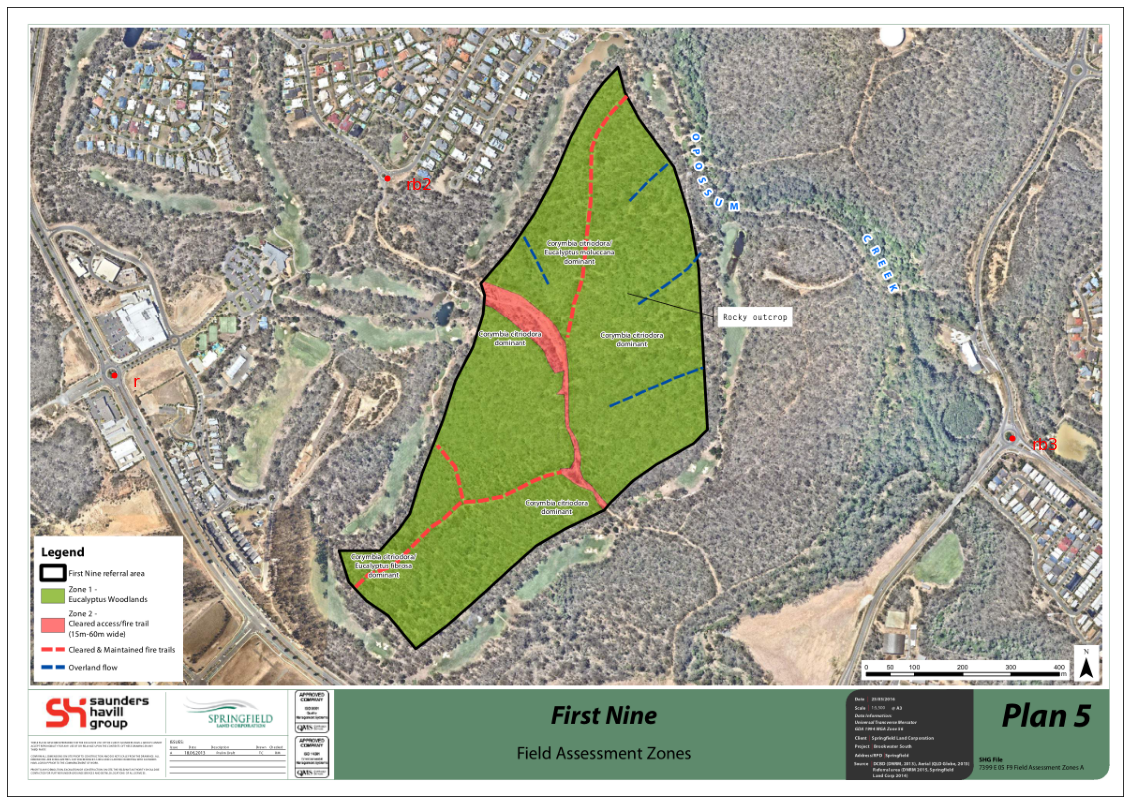

In [151]:
fig, ax = plt.subplots(1, figsize=(20,20))
ax.imshow(im1)
for i in range(len(points)):
    ax.plot(points[i][0], points[i][1], '.r', markersize=10)
    ax.text(points[i][0]+20, points[i][1]+12, names[i], color='r', fontsize=16)
    plt.tick_params(        
        which='both',     
        bottom=False,     
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False
    )
fig.savefig(base_dir + sub_dir + '/reference.png')

In [152]:
approx_lon = input(
    'Enter approx. lon. of top left map corner in dec. degrees '
    + '(e.g. 150.12345678): '
)
approx_lon = float(approx_lon)
approx_lat = input(
    'Enter approx. lat. of top left map corner in signed dec. degrees '
    + '(e.g. -25.12345678): '
)
approx_lat = float(approx_lat)
approx_spread = input(
    'Enter approx. width of map in dec. degrees (e.g. 0.05): '
)
approx_spread = float(approx_spread)

Enter approx. lon. of top left map corner in dec. degrees (e.g. 150.12345678): 152.889811
Enter approx. lat. of top left map corner in signed dec. degrees (e.g. -25.12345678): -27.663541
Enter approx. width of map in dec. degrees (e.g. 0.05): .02


In [56]:
-27.667762, 152.875469

'q'

In [ ]:
-27.663541, 152.889811

In [ ]:
-27.484137, 152.267232

In [153]:
# Here we can usually be more precise by centering on state of project
scaled_points = [
    (
        approx_spread*x[0]/im1.shape[0] + approx_lon,
        -approx_spread*x[1]/im1.shape[1] + approx_lat
    ) for x in points
]

In [154]:
import subprocess
import geojson

In [155]:
subprocess.run('rm -r ' + base_dir + sub_dir + '/JSON', shell=True)
subprocess.run('mkdir ' + base_dir + sub_dir + '/JSON', shell=True)

json_features = []
for i in range(len(scaled_points)):
    json_feature = geojson.Feature(
        geometry=geojson.Point(
            scaled_points[i], precision=8, properties={'Name': names[i]}
        )
    )
    json_features.append(json_feature)
    
for i in range(len(json_features)):
    f = open(base_dir + sub_dir + '/JSON/' + names[i] + '.json', 'w')
    f.write(geojson.dumps(json_features[i], sort_keys=True, indent=4))
    f.close()

In [156]:
subprocess.run(
    'cp ' + base_dir + '/reference.qgs ' + base_dir 
    + sub_dir + '/reference.qgs', shell=True
)
subprocess.run(
    'qgis --project ' + base_dir + sub_dir + '/reference.qgs ' 
    + base_dir + sub_dir + '/JSON/*.json', shell=True
)

CompletedProcess(args='qgis --project /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/map_data/20167676_01042016/reference.qgs /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/map_data/20167676_01042016/JSON/*.json', returncode=0)

In [161]:
coords = []
for i in range(len(points)):
    f = open(base_dir + sub_dir + '/JSON/' + names[i] + '.json', 'r')
    coords.append(geojson.loads(f.read()))
    f.close()

In [162]:
rows = np.array([point[1] for point in points])
cols = np.array([point[0] for point in points])
lons = np.array(
    [coord['geometry']['coordinates'][0] for coord in coords]
)
lats = np.array(
    [coord['geometry']['coordinates'][1] for coord in coords]
)

In [163]:
X = cols/im1.shape[1]
Y = rows/im1.shape[0]

if len(rows) < 3:
    A = None
elif len(rows) < 5:
    A = lambda x,y: np.array([x*0+1, x, y])
else:
    A = lambda x,y: np.array([x*0+1, x, y, x**2, x*y, y**2])

c_lon, residuals, rank, s = np.linalg.lstsq(A(X,Y).T, lons, rcond=None)
c_lat, residuals, rank, s = np.linalg.lstsq(A(X,Y).T, lats, rcond=None)

def evaluate_paraboloid(x,y,coeff):
    c = copy.deepcopy(coeff)
    x = np.array(x)
    y = np.array(y)
    for i in range(len(x.shape)):
        c = np.expand_dims(c, axis=1)
    return (c*A(x,y)).sum(axis=0)

x = np.arange(im1.shape[1])/im1.shape[1]
y = np.arange(im1.shape[0])/im1.shape[0]
XX, YY = np.meshgrid(x, y)

LON = evaluate_paraboloid(XX, YY, c_lon)
LAT = evaluate_paraboloid(XX, YY, c_lat)

In [164]:
gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)

structure = feature.canny(gray, sigma=1).astype(np.uint8)
con_structure, hierarchy = cv.findContours(
    structure, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_TC89_L1
)
main_box = [c for c in con_structure if 0.5*im1_area < cv.contourArea(c) < im1_area]
main_box = cv.drawContours(
    np.zeros_like(gray), main_box, 0, 255, -1
)
legend_box = np.zeros_like(im1[:,:,0])
legend_box[rec[2]:rec[2]+rec[0], rec[3]:rec[3]+rec[1]] = 1

filt_result = copy.deepcopy(result)
# filt_result[main_box == 0] = 0
filt_result[legend_box == 1] = 0

In [165]:
np.unique(filt_result)

array([ 0,  3,  9, 19, 21, 23, 24, 26, 27, 29, 30, 33, 34, 36])

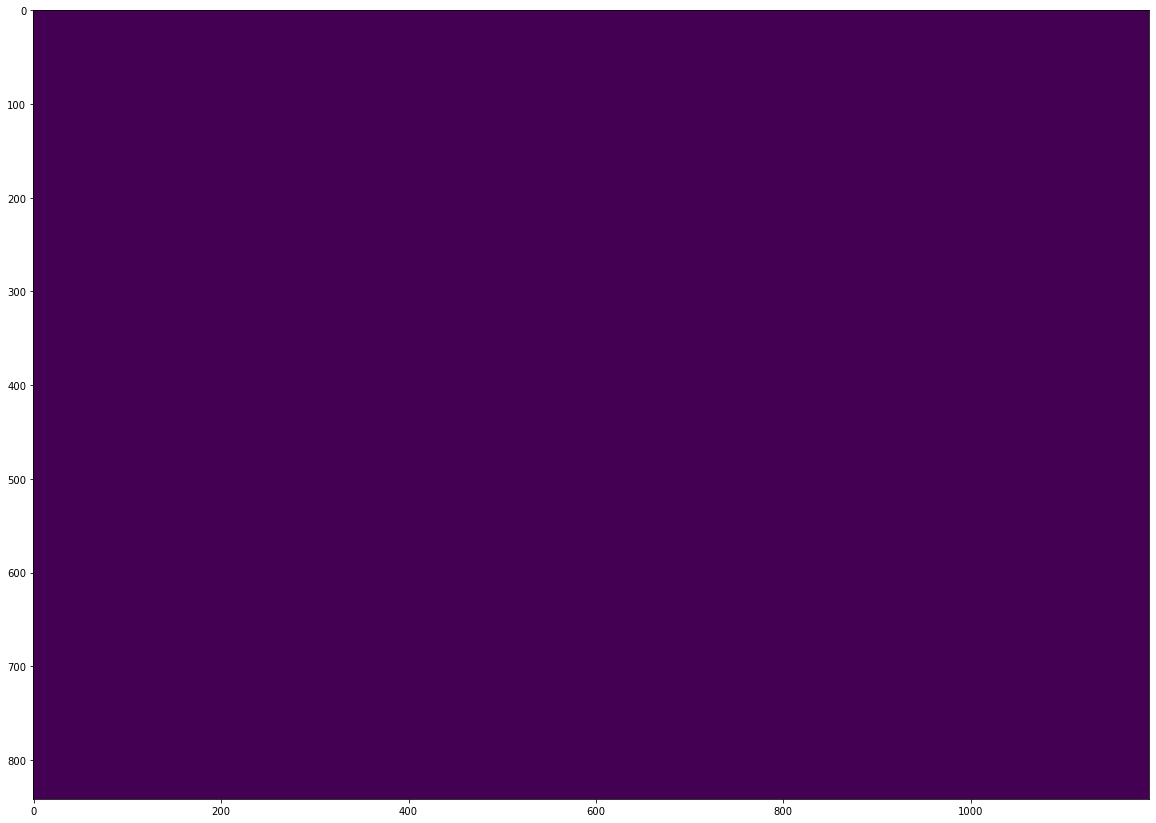

In [166]:
fig, ax = plt.subplots(figsize=(20,20))
# plt.imshow(ndi.binary_fill_holes(filt_result==27))

filled = ndi.binary_fill_holes(filt_result==32)
obj_size_ratio = 5e-5
min_size = int(obj_size_ratio*im1.shape[0]*im1.shape[1])
filled = remove_small_objects(filled, min_size = min_size)
label_objects, nb_labels = ndi.label(filled)
label_objects = label_objects.astype(np.uint8)

ax.imshow(skimage.morphology.binary_closing(label_objects>0, selem=np.ones((5,5))))

In [167]:
# inds = np.unique(leg_obj_labels).tolist()
inds = np.unique(filt_result).tolist()
inds.remove(0)

num_colours = len(inds)
alpha=0.75
cm = pylab.get_cmap('Set1')
poly_colours = []
line_colours = []

for i in range(num_colours):
    cp = list(cm(1.*i/num_colours))
    cline = copy.deepcopy(cp)
    cp[3] = alpha
    cp = to_hex(cp, keep_alpha=True)[1:]
    cp = cp[6:]+cp[4:6]+cp[2:4]+cp[0:2]
    poly_colours.append(cp)
    cline = (np.array(cline)*0.8).tolist()
    cline[3] = alpha
        
    cline = to_hex(cline, keep_alpha=True)[1:]
    cline = cline[6:]+cline[4:6]+cline[2:4]+cline[0:2]
    line_colours.append(cline)

In [168]:
leg_blocks_text

['Legend',
 'First Nine referral area',
 'Zone 1 -Eucalyptus Woodlands',
 'Zone 2 -Cleared access/fire trail(15m-60m wide)',
 'Cleared & Maintained fire trails',
 'Overland flow']

In [169]:
from tkinter import Canvas

kml = simplekml.Kml()
kml.document.name = file_name

styles = []
for i in range(len(inds)):
    sty = simplekml.Style()
    sty.linestyle.width = 2
    sty.linestyle.color = line_colours[i]
    sty.polystyle.color = poly_colours[i]
    styles.append(sty)
    
for i in range(len(inds)):
    filled = ndi.binary_fill_holes(filt_result==inds[i])
    obj_size_ratio = 5e-5
    min_size = int(obj_size_ratio*im1.shape[0]*im1.shape[1])
    filled = remove_small_objects(filled, min_size = min_size)
    filled = skimage.morphology.binary_closing(
        filled, selem=np.ones((5,5))
    )
    filled = ndi.binary_fill_holes(filled)
    
    label_objects, nb_labels = ndi.label(filled)
    label_objects = label_objects.astype(np.uint8)

    if np.any(label_objects>0):
        
        root = tk.Tk()
        root.attributes('-zoomed', True)
        root.title('Click to choose polygons.')

        root.canvas = tk.Canvas(
            root, width=100, height=100, cursor='tcross'
        )
        root.canvas.pack(expand = 'yes', fill = 'both')

        label_objects_tk = ((label_objects>0)*180).astype(np.uint8)
        im = Image.fromarray(label_objects_tk)
        ph = ImageTk.PhotoImage(image=im)
        root.canvas.ph = ph

        root.canvas.create_image(0, 0, image = root.canvas.ph, anchor = 'nw')
        root.canvas.ph = ph
       
        #function to be called when mouse is clicked
        def highlight_poly(event):
                
            x, y = [event.x, event.y]
            ind = label_objects[y,x]
            if label_objects_tk[y,x] == 180:
                label_objects_tk[label_objects==ind] = 255
            elif label_objects_tk[y,x] == 255:
                label_objects_tk[label_objects==ind] = 180
            im = Image.fromarray(label_objects_tk)
            ph = ImageTk.PhotoImage(image=im)
            root.canvas.ph = ph
            root.canvas.create_image(0, 0, image = root.canvas.ph, anchor = 'nw')

        root.canvas.bind("<Button 1>", highlight_poly)
        root.mainloop()
        
        label_objects[label_objects_tk!=255] = 0
        if np.any(label_objects_tk==255) and  inds[i] not in leg_inds:
            name = input('Name this class of Polygons: ')
        elif inds[i] in leg_inds:
            name = leg_blocks_text[box_nums[i]]
        else:
            name = str(i)
    
    obj_contours, hierarchy = cv.findContours(
        label_objects, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_TC89_L1
    )
    
    smooth_obj_contours = []
    for cnt in obj_contours:
        if len(cnt) > 3:
            epsilon = 0.002*cv.arcLength(cnt,True)
            smooth_obj_contours.append(
                cv.approxPolyDP(cnt,epsilon,True)
            )
            
    poly_coords = [
        [
            (
                LON[
                    smooth_obj_contours[i][j][0][1],
                    smooth_obj_contours[i][j][0][0]
                ],
                LAT[
                    smooth_obj_contours[i][j][0][1],
                    smooth_obj_contours[i][j][0][0]
                ],
                1.0
            )
            for j in range(len(smooth_obj_contours[i]))
        ]
        for i in range(len(smooth_obj_contours))
    ]
    
    if poly_coords:
        fol = kml.newfolder(name=name)
        for j in range(len(poly_coords)):
            poly = fol.newpolygon(
                name = name + ' ' + str(j+1),
                outerboundaryis = poly_coords[j] + [poly_coords[j][0]],
                altitudemode='relativetoground',                
            )
            poly.style = styles[i]
kml.save(base_dir + sub_dir + '/' + str(page_num) + '_polygons.kml')

Name this class of Polygons: Zone1
Name this class of Polygons: Zone1again
Name this class of Polygons: cleared fire trail
Name this class of Polygons: zone1
